In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors.kde import KernelDensity
import umap
from fast_tsne import fast_tsne

sys.path.append('Modules')

import rnaseqTools
import file_navigation
import read_data

color_dict = file_navigation.get_color_dict(fname='Gauwens_colors')

In [2]:
def trim_data(df, n=150, min_num=10):
    df = df.loc[:,(df.values>32).sum(axis=0)>=min_num]
    df = df.loc[:,(df.values<0.5).sum(axis=0)>=min_num]
    df = np.log2(1+df)
    importantGenes = rnaseqTools.geneSelection(df.values, n=n, threshold=5, plot=False)
    df = df.loc[:,importantGenes]
    
    return df

def perform_feature_selection(df, trim_num=10):
    df = trim_data(df, min_num=trim_num)
    pca = PCA(n_components=min(50, df.shape[0]))
    datalist = pca.fit_transform(df.values)
    df_pca = pd.DataFrame(datalist, index=df.index)
    
    return df_pca

def embedding_plot(df, ax, color_dict, trim_num=10, to_trim=True):
    if to_trim:
        df_pca = perform_feature_selection(df, trim_num=trim_num)
    else:
        df_pca = df
    reducer = umap.UMAP(n_components=2, n_neighbors=10, min_dist=.01, random_state=42, metric='euclidean')
    plotlist = reducer.fit_transform(df_pca.values)
    
    celltypes = df_pca.index.get_level_values('CellType')
    for celltype in set(celltypes):
        inds = celltypes==celltype
        color = color_dict[celltype]
        ax.scatter(plotlist[inds,0], plotlist[inds,1], color=color, s=8, linewidth=.1)
        
    ax.set_xticks([]), ax.set_yticks([])
    return

def get_reductions(df):
    fname = 'Mapping/MarkerGenes/Harris_Genes.txt'
    with open(fname) as f:
        genes = [line.split()[0] for line in f]
    
    df_reduction = df.loc[:,genes].copy()
    
    return df_reduction

def get_data():
    df_tpm, df_labels = read_data.read_tpm_data('Gauwens')
    arrays = df_labels.index, df_labels.CellType
    names = ('Cell', 'CellType')
    df_tpm.columns = pd.MultiIndex.from_arrays(arrays, names=names)
    #df_nbtsne = read_data.read_embedding_data('Harris_nbtSNE')
    
    #df_nbtsne = df_nbtsne.loc[df_tpm.columns,:].copy()
    df_tpm = df_tpm.T
    
    df_part = get_reductions(df_tpm)
    
    return df_tpm, df_part

def get_embeddings(df_pca):
    """
    given a dataframe, generate the 2-dimensional embeddings for it
    """
    
    # Step 0: Initialize variables
    columns = ['Plot_X', 'Plot_Y']
    
    # Step 2: Calculate embeddings
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    datalist = tsne.fit_transform(df_pca.values)
    df_tsne = pd.DataFrame(datalist, index=df_pca.index, columns=columns)
    
    reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=.75, random_state=42, metric='euclidean')
    datalist = reducer.fit_transform(df_pca.values)
    df_umap = pd.DataFrame(datalist, index=df_pca.index, columns=columns)
    
    datalist = fast_tsne(df_pca.values, perplexity_list = [30,int(df_pca.shape[0]/100)],
                            learning_rate = df_pca.shape[0]/12, knn_algo='vp-tree', seed=42)
    df_fit = pd.DataFrame(datalist, index=df_pca.index, columns=columns)
    
    
    return df_tsne, df_umap, df_fit

def plot_embedding(ax, df, colors, title, s=1):
    ax.set_title(title, fontsize=12)
    ax.set_xticks([]), ax.set_yticks([])
    ax.scatter(df.Plot_X, df.Plot_Y, color=colors, s=s, alpha=.25)
    
    return

def read_in_dataset(dataset):
    params = {'sep':'\t', 'header':0, 'index_col':0}
    fname = 'Datasets/%s-tpm.tsv' % dataset
    df = pd.read_csv(fname, **params)
    
    return df

def generate_subset_data(dataset, df_embed, save_title, continents):
    df = read_in_dataset(dataset)
    fname = 'References/Gauwens_Continents.txt'
    df_continent = pd.read_csv(fname, sep='\t', header=0, index_col=0)
    df_continent = df_continent.loc[df_continent.Continent.isin(continents),:]
    
    df_zoom = df_embed.loc[df_embed.index.get_level_values('CellType').isin(df_continent.index),:]
    df = df.loc[:,df_zoom.index.get_level_values('Cell').astype(str)]
    
    low_val = df_zoom.quantile(.02)
    high_val = df_zoom.quantile(.98)
    step = .05 * (high_val - low_val)
    low_val = low_val - step
    high_val = high_val + step
    
    keep_vars = np.array([np.logical_and(data>low, data<high)
                          for data, low, high
                          in zip(df_embed.values.T, low_val, high_val)
                         ]
                        )
    keep = keep_vars.sum(axis=0) == keep_vars.shape[0]
    
    df_embed = df_embed.loc[keep,:]
    
    df.to_csv('Mapping/DataSubsets/%s.tsv' % save_title, sep='\t')
    df_embed.to_csv('Mapping/DataSubsets/%s-embedding.tsv' % save_title, sep='\t')
    
    return

In [3]:
def get_separator_genes(fname='Gauwens/Sst vs Pvalb'):
    fname = 'Differential/edgeR/%s.txt' % fname
    df = pd.read_csv(fname, sep='\t', header=0, index_col=0)
    
    genes = [df.loc[df.logFC>1,:].head(n=10).index.tolist(), df.loc[df.logFC<-1,:].head(n=10).index.tolist()]
    
    return genes

def get_kde(data):
    step = data.std()/2 + .001
    if data.min() == data.max():
        data = np.random.rand(data.size)*.01 + data.min()
    xvals = np.linspace(0, 1.2, 60)
    kde = KernelDensity(kernel='gaussian', bandwidth=step).fit(data[:,np.newaxis])
    log_dens = np.exp(kde.score_samples(xvals[:,np.newaxis]))
    log_data = np.exp(kde.score_samples(data[:,np.newaxis]))
    
    return xvals, log_dens, log_data


def break_up_kde(xvals, log_dens, cutoff=.01):
    to_plot = log_dens>=cutoff
    
    if to_plot.sum() == to_plot.size:
        return [xvals], [log_dens]
    elif to_plot.sum() == 0:
        return [], []
    
    inds = np.arange(to_plot.size,dtype=int)[to_plot]
    
    sub_inds = np.split(inds, np.arange(inds.size-1,dtype=int)[np.diff(inds)>1]+1)
    sub_inds = [sub_ind if sub_ind.size>1 else [sub_ind[0],sub_ind[0]] for sub_ind in sub_inds]
    
    xvals = [xvals[sub_ind] for sub_ind in sub_inds]
    log_dens = [log_dens[sub_ind] for sub_ind in sub_inds]
    
    return xvals, log_dens

def get_normalized_kde(data, high=4, width=.4):
    xvals, log_dens, log_data = get_kde(data)
    peak = max(high, log_dens.max())
    log_dens = log_dens / peak * width
    log_data = log_data / peak * width
    
    xvals, log_dens = break_up_kde(xvals, log_dens, cutoff=.01)
    
    return xvals, log_dens

def plot_gene_violin(data, ax, celltypes, colors):
    high = data.max()
    if high == 0:
        return
    data = data / high
    
    data1 = data.loc[data.index.get_level_values('CellType').isin(celltypes[0])]
    data2 = data.loc[data.index.get_level_values('CellType').isin(celltypes[1])]
    yvals1, log_dens1 = get_normalized_kde(data1, high=4, width=.4)
    yvals2, log_dens2 = get_normalized_kde(data2, high=4, width=.4)
    
    kwargs = {'edgecolor':'#000000', 'linewidth':.5, 'zorder':0}
    for yvals, log_dens in zip(yvals1, log_dens1):
        ax.fill_betweenx(yvals, -.5+log_dens, -.5-log_dens, facecolor=colors[0], **kwargs)
    for yvals, log_dens in zip(yvals2, log_dens2):
        ax.fill_betweenx(yvals, .5+log_dens, .5-log_dens, facecolor=colors[1], **kwargs)
        
    #ax.plot([0,1.5], [0,0], linewidth=.1, color='black')
    
    return

def do_split_violin_plots(df_tpm, fig, top, fname='Gauwens/Sst vs Pvalb'):
    genes = get_separator_genes(fname=fname)
    celltypes = df_tpm.columns.get_level_values('CellType')
    celltypes = [np.unique(celltypes[celltypes.str.startswith('Pvalb')]),
                 np.unique(celltypes[celltypes.str.startswith('Sst')])]
    cells = [cell for celltype in celltypes for cell in celltype]
    genelist = [gene for gene_set in genes for gene in gene_set]
    df = np.log2(1+df_tpm.loc[genelist,df_tpm.columns.get_level_values('CellType').isin(cells)])
    
    Width = .05
    Height = .03
    Left = .2
    Bottom = top - Height
    
    for row, gene_set in enumerate(genes):
        for col, gene in enumerate(gene_set):
            ax = fig.add_axes([Left+Width*col, Bottom-.1*row, Width, Height])
            ax.axis([-1,1,-.02,1.3])
            ax.set_yticks([])
            ax.set_xticks([.75])
            ax.set_xticklabels([gene], rotation=90, ha='center', fontsize=6)
            ax.tick_params(size=0)
            
            plot_gene_violin(df.loc[gene], ax, celltypes, colors)
    
    return

In [4]:
%%time

df_tpm, df_part = get_data()
df_pvalb = df_tpm.loc[df_tpm.index.get_level_values('CellType').str.startswith('Pvalb')]
df_sst = df_tpm.loc[df_tpm.index.get_level_values('CellType').str.startswith('Sst')]
df_int = pd.concat((df_pvalb, df_sst), axis=0)

CPU times: user 23.7 s, sys: 828 ms, total: 24.6 s
Wall time: 24.6 s


In [5]:
%%time

pca = PCA(n_components=50)

# Step 1: Normalize the data
datalist = np.log2(1+df_part.values)
datalist = pca.fit_transform(datalist)

df_pca = pd.DataFrame(datalist, index=df_part.index)

CPU times: user 291 ms, sys: 209 ms, total: 500 ms
Wall time: 49.3 ms


In [6]:
%%time

df_tsne, df_umap, df_fit = get_embeddings(df_pca)

/home/soma/anaconda3/envs/analyze/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../../../anaconda3/envs/analyze/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/soma/anaconda3/envs/analyze/lib/python3.6/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../../../anaconda3/envs/analyze/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  state.func_ir.loc))
/home/soma/anaconda3/envs/analyze/lib/p

CPU times: user 30.1 s, sys: 2.43 s, total: 32.5 s
Wall time: 1min 7s


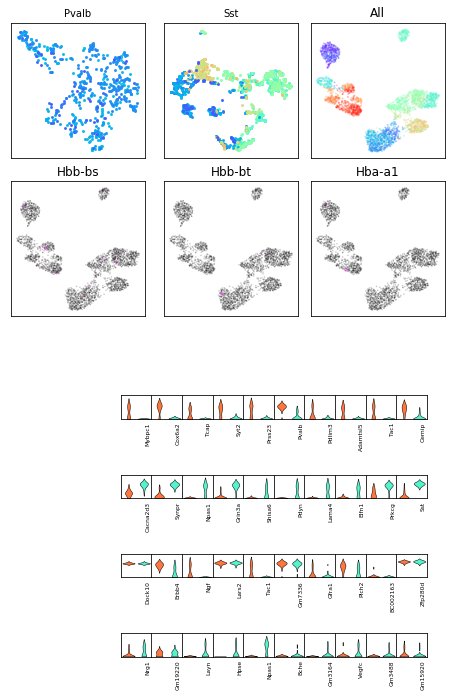

CPU times: user 31.1 s, sys: 3.34 s, total: 34.4 s
Wall time: 28.7 s


In [10]:
%%time

colors = df_tpm.index.get_level_values('CellType').map(color_dict)
fig = plt.figure(figsize=(8.5,11))

ax = fig.add_axes([.51, .7, .22, .17])
plot_embedding(ax, df_umap, colors, 'All')

ax = fig.add_axes([.02, .7, .22, .17])
ax.set_title('Pvalb', fontsize=10)
embedding_plot(df_pvalb, ax, color_dict)

ax = fig.add_axes([.27, .7, .22, .17])
ax.set_title('Sst', fontsize=10)
embedding_plot(df_int, ax, color_dict)

hb_data = df_tpm.loc[:,'Hbb-bs'].values
hb_data = hb_data / hb_data.max()
colors = [(data, 0, data) for data in hb_data]
s = 0.2+8*hb_data

ax = fig.add_axes([.02, .5, .22, .17])
plot_embedding(ax, df_umap, colors, 'Hbb-bs', s=s)

hb_data = df_tpm.loc[:,'Hbb-bt'].values
hb_data = hb_data / hb_data.max()
colors = [(data, 0, data) for data in hb_data]
s = 0.2+8*hb_data

ax = fig.add_axes([.27, .5, .22, .17])
plot_embedding(ax, df_umap, colors, 'Hbb-bt', s=s)

hb_data = df_tpm.loc[:,'Hba-a1'].values
hb_data = hb_data / hb_data.max()
colors = [(data, 0, data) for data in hb_data]
s = 0.2+8*hb_data

ax = fig.add_axes([.51, .5, .22, .17])
plot_embedding(ax, df_umap, colors, 'Hba-a1', s=s)



colors = df_tpm.index.get_level_values('CellType').map(color_dict)
do_split_violin_plots(df_tpm.T, fig, 0.40)
do_split_violin_plots(df_tpm.T, fig, 0.20, fname='General/Sst-OLM vs Pvalb')

fig.savefig('Mapping/Plots/Embedding_Plots_2.pdf')
plt.show()

In [8]:
%%time

df_tsne.to_csv('Mapping/Embeddings/Gauwens_tSNE.tsv', sep='\t')
df_umap.to_csv('Mapping/Embeddings/Gauwens_UMAP.tsv', sep='\t')
df_fit.to_csv('Mapping/Embeddings/Gauwens_FIt_tSNE.tsv', sep='\t')

CPU times: user 39.9 ms, sys: 3.99 ms, total: 43.9 ms
Wall time: 44.3 ms


In [9]:
%%time

generate_subset_data('Gauwens', df_umap, 'Gauwens_Pvalb', [1])

CPU times: user 41 s, sys: 597 ms, total: 41.6 s
Wall time: 41.6 s
